# Sampling approximation

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from src.optimal_transport import semi_discrete_ot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Sampling approximation when the "ground-truth" Monge map  is known

Method for experiment:

In [2]:
def experiment_1(phi, grid_size, list_N, nb_exp, grid_gradient=200):
    """
    Defines 1st experiment comparing the transport plan estimated from
    empirical samples to the ground-truth transport plan, taken as the
    gradient of a convex function 'phi'.
    Args:
        phi (function): convex function defined on R² (takes two real arguments)
        grid_size (int): discretization parameter for the transport plans
                             (m in the paper)
        list_N (list): list of number of samples 
        nb_exp (int): number of time each experience is repeated
        grid_gradient (int): discretization parameter for approximating
                            the gradient of phi
    Returns:
        array_distances (array): array of size len(list_N) x np_exp gathering
                                the distances between the estimated transport
                                plans and the ground truth transport plan
    """
    # array to save distance between empirical and true transport plans
    array_distances = np.zeros((len(list_N), nb_exp))
    
    # GROUND TRUTH
    # approximate target distribution as the push-forward by the gradient
    # of 'phi' of the uniform measure on [0, 1]² (this gradient is approximated)
    X, Y = np.meshgrid(np.linspace(0, 1, grid_gradient), np.linspace(0, 1, grid_gradient))
    h = 2/(grid_gradient-1)
    Z = phi(X, Y)
    GX, GY = np.gradient(Z, h, h)
    target_distribution = np.hstack((GX.reshape((-1, 1)), GY.reshape((-1, 1))))
    # deduce "ground-truth" transport plan (take vector approximation)
    sd_ot_gt = semi_discrete_ot(grid_size=grid_size)
    sd_ot_gt.fit_transport_plans({0: target_distribution})
    gt_transport_plan = sd_ot_gt.transport_plans
    
    # ESTIMATES
    # for N in list_N, compute the distance between the ground-truth map
    # and the map estimated from N samples (repeat 'nb_exp' times)
    for id_N in range(len(list_N)):
        N = int(list_N[id_N])
        # create 'nb_exp' empirical samples of size N each
        point_clouds = {}
        for exp in range(nb_exp):
            # create point cloud (empirical sample) by looking at the push forward of
            # points sampled uniformly on [0, 1]² by the ground-truth transport map
            point_cloud = target_distribution[np.random.choice(grid_gradient**2, N, replace=True)]
            point_clouds[exp] = point_cloud
        # compute approximate transport plans
        sd_ot = semi_discrete_ot(grid_size=grid_size)
        sd_ot.fit_transport_plans(point_clouds)
        # deduce distance between approximate transport plans and ground-truth transport plan
        dist_2 = 1/(grid_size**2) * np.sum((sd_ot.transport_plans - gt_transport_plan)**2, axis=1)
        array_distances[id_N] = np.sqrt(dist_2)
        
    return array_distances 


def plot_target(phi, title='', color='b', N=100):
    # sample from the measure defined with phi
    X, Y = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
    h = 1/(N-1)
    Z = phi(X, Y)
    GX, GY = np.gradient(Z, h, h)
    # plot samples
    plt.scatter(GX, GY, c=color)
    plt.title(title)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    #plt.show()

Parameters for this experiment:

In [3]:
nb_N = 10
inf_log_N = 1
sup_log_N = 2.7
list_N = np.logspace(inf_log_N, sup_log_N, nb_N)

nb_exp = 25

grid_size = 200

Define the **"disk"** measure with $$\phi_{\text{Disk}}(x, y) := 0.25(x+y) + 0.07(|x+y|^{3/2} + |x-y|^{3/2})$$

In [4]:
def phi_disk(X, Y, p=1.5):
    X = 2*X - 1
    Y = 2*Y -1
    return 0.25 *(X + Y) + 0.07 * (np.abs(X+Y)**p+np.abs(X-Y)**p) 

Run experiment for this measure:

In [5]:
np.random.seed(2)

distances_disk = experiment_1(phi_disk, grid_size, list_N, nb_exp)

Define the **"cross"** measure with $$\phi_{\text{Cross}}(x, y) := 0.5(x+y) + 0.04 \max(4(x+y-1)^2 + 0.5(2x-1)^2 + 0.5(2y-1)^2, 4(x-y)^2 + 0.5(2x-1)^2 + 0.5(2y-1)^2)$$

In [6]:
def phi_cross(X, Y):
    return 0.5*(X + Y) + 0.04*np.maximum(((2*X-1)+(2*Y-1))**2+0.5*((2*X-1)**2+(2*Y-1)**2),
                                          4*(X-Y)**2+0.5*((2*X-1)**2+(2*Y-1)**2))

Run experiment for this measure:

In [7]:
np.random.seed(2)

distances_cross = experiment_1(phi_cross, grid_size, list_N, nb_exp)

/home/alex/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Define the **"square"** measure with $$\phi_{\text{Square}}(x, y) :=  0.5(x^2 + y^2)$$

In [8]:
def phi_square(X, Y):
    return 0.5 * (X**2 + Y**2) 

Run experiment for this measure:

In [9]:
np.random.seed(2)

distances_square = experiment_1(phi_square, grid_size, list_N, nb_exp)

Plot target measures:

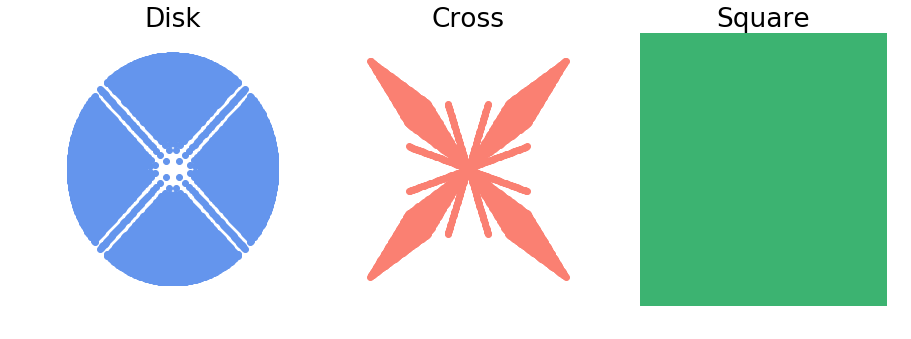

In [10]:
fig = plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 22})

plt.subplot(1, 3, 1)
plot_target(phi_disk, title="Disk", color="cornflowerblue")

plt.subplot(1, 3, 2)
plot_target(phi_cross, title="Cross", color="salmon")

plt.subplot(1, 3, 3)
plot_target(phi_square, title="Square", color="mediumseagreen")

plt.show()

fig.savefig("target_measures.pdf", bbox_inches='tight')

Plot results:

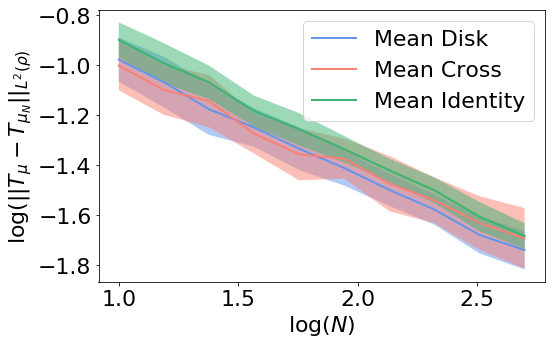

In [11]:
log_distances_disk = np.log10(distances_disk)
mean_disk = np.mean(log_distances_disk, axis=1)
std_disk = np.std(log_distances_disk, axis=1)

log_distances_cross = np.log10(distances_cross)
mean_cross = np.mean(log_distances_cross, axis=1)
std_cross = np.std(log_distances_cross, axis=1)

log_distances_square = np.log10(distances_square)
mean_square = np.mean(log_distances_square, axis=1)
std_square = np.std(log_distances_square, axis=1)


fig = plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 22})

plt.plot(np.log10(list_N), mean_disk, lw=2, label='Mean Disk', color='cornflowerblue')
plt.fill_between(np.log10(list_N), mean_disk+std_disk, mean_disk-std_disk, facecolor='cornflowerblue', alpha=0.5)

plt.plot(np.log10(list_N), mean_cross, lw=2, label='Mean Cross', color='salmon')
plt.fill_between(np.log10(list_N), mean_cross+std_cross, mean_cross-std_cross, facecolor='salmon', alpha=0.5)

plt.plot(np.log10(list_N), mean_square, lw=2, label='Mean Identity', color='mediumseagreen')
plt.fill_between(np.log10(list_N), mean_square+std_square, mean_square-std_square, facecolor='mediumseagreen', alpha=0.5)

plt.xlabel(r"$\log(N)$") 
plt.ylabel(r"$\log(||T_{\mu} - T_{\mu_N}||_{L^2(\rho)}$") 
#plt.ylim(-1e-3, 8e-3)
plt.legend()

fig.savefig("scaling_N.pdf", bbox_inches='tight')

## Sampling approximation when the "ground-truth" Monge map  is unknown

Method for the experiment:

In [12]:
def experiment_2(sampling_fn, grid_size, list_N, nb_exp):
    """
    Defines 2nd experiment comparing the transport plan estimated from
    empirical samples to an approximate ground-truth transport plan, estimated
    from a great number (10,000) of empirical samples.
    Args:
        sampling_fn (function): takes one integer argument N and returns N points
                                sampled from the distribution of interest
        grid_size (int): discretization parameter for the transport plans
                             (m in the paper)
        list_N (list): list of number of samples 
        nb_exp (int): number of time each experience is repeated
    Returns:
        array_distances (array): array of size len(list_N) x np_exp gathering
                                the distances between the estimated transport
                                plans and the ground truth transport plan
    """    
    # array to save distance between empirical and true transport plans
    array_distances = np.zeros((nb_N, nb_exp))
    
    # compute "ground-truth" transport plan
    gt_cloud = sampling_fn(10000)
    gt_ot = semi_discrete_ot(grid_size=grid_size)
    gt_ot.fit_transport_plans({0: gt_cloud})
    gt_transport_plan = gt_ot.transport_plans

    # compute distances nb_exp times for each N of list_N
    for id_N in range(len(list_N)):
        N = int(list_N[id_N])
        # create 'nb_exp' empirical samples of size N each
        point_clouds = {}
        for exp in range(nb_exp):
            # create point cloud
            point_cloud = sampling_fn(N)
            point_clouds[exp] = point_cloud
        # compute approximate transport plans
        sd_ot = semi_discrete_ot(grid_size=grid_size)
        sd_ot.fit_transport_plans(point_clouds)
        # deduce distance between approximate transport plans and ground-truth transport plan
        dist_2 = 1/(grid_size**2) * np.sum((sd_ot.transport_plans - gt_transport_plan)**2, axis=1)
        array_distances[id_N] = np.sqrt(dist_2)

    return array_distances


def plot_density(cloud, title=''):
    # Extract x and y
    x = cloud[:, 0]
    y = cloud[:, 1]# Define the borders
    deltaX = 1/10
    deltaY = 1/10
    xmin = - deltaX
    xmax = 1 + deltaX
    ymin = 0 - deltaY
    ymax = 1 + deltaY
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 22})
    ax = fig.gca()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.title(title)

**Gaussian:**

In [13]:
def sampling_fn_gaussian(N):
    mean = np.array([0.5, 0.5])
    cov = 5e-3 * np.array([[1, -0.3], [-0.3, 2]])
    return np.random.multivariate_normal(mean, cov, N)

Plot estimated density:

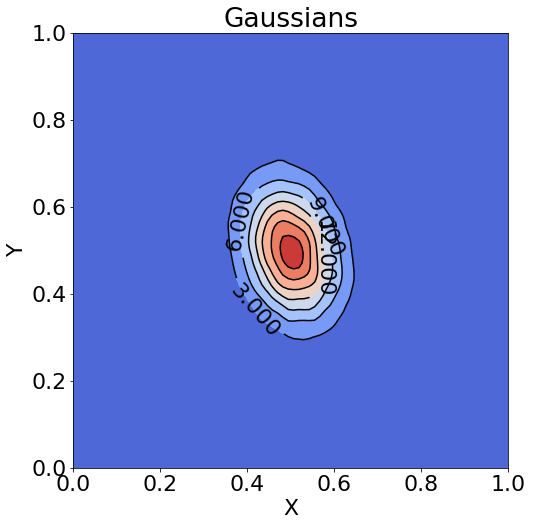

In [14]:
np.random.seed(2)

cloud = sampling_fn_gaussian(50000)
plot_density(cloud, title='Gaussians')

Run experiment for this measure:

In [15]:
np.random.seed(2)

distances_gaussian = experiment_2(sampling_fn_gaussian, grid_size, list_N, nb_exp)

**Mixture of Gaussians:**

In [16]:
def sampling_fn_mixture_gaussians(N):
    means = np.array([[0.7, 0.7],
                      [0.3, 0.8],
                      [0.5, 0.4], 
                      [0.2, 0.3]])
    covs = 1e-3 * np.array([[[1, -0.3], [-0.3, 2]],
                            [[0.5, 0.2], [0.2, 0.8]],
                            [[0.8, -0.7], [-0.7, 1]],
                            [[1, -0.8], [-0.8, 3]]])
    sample = np.zeros((N, 2))
    for i in range(N):
        j = np.random.randint(4)
        sample[i] = np.random.multivariate_normal(means[j], covs[j], 1)
    return sample

Plot estimated density:

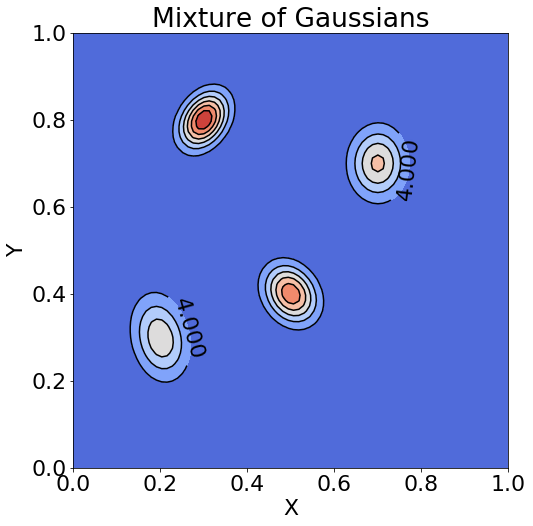

In [17]:
np.random.seed(2)

cloud = sampling_fn_mixture_gaussians(100000)
plot_density(cloud, title='Mixture of Gaussians')

Run experiment for this measure:

In [18]:
np.random.seed(2)

distances_mixture_gaussians = experiment_2(sampling_fn_mixture_gaussians, grid_size, list_N, nb_exp)

**Uniform:**

In [19]:
def sampling_fn_uniform(N):
    return 0.02 + 0.96 * np.random.rand(N, 2)

Plot estimated density:

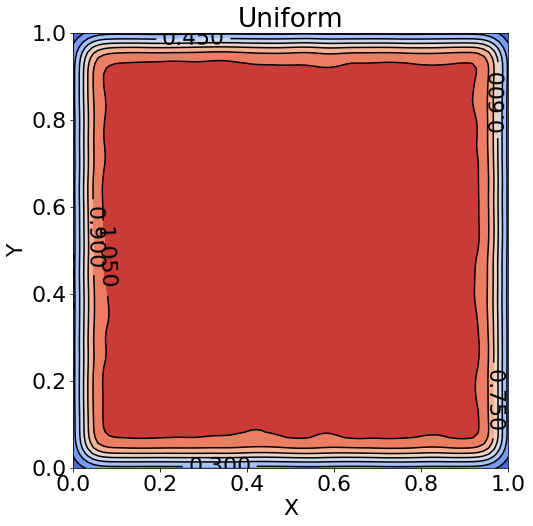

In [20]:
np.random.seed(2)

cloud = sampling_fn_uniform(1000000)
plot_density(cloud, title='Uniform')

Run experiment for this measure:

In [21]:
np.random.seed(2)

distances_uniform = experiment_2(sampling_fn_uniform, grid_size, list_N, nb_exp)

Plot results:

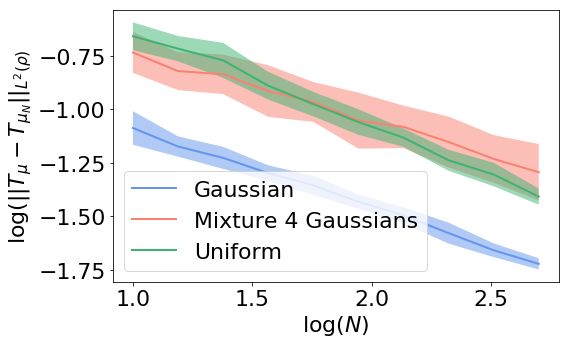

In [22]:
log_distances_gaussian = np.log10(distances_gaussian)
mean_gaussian = np.mean(log_distances_gaussian, axis=1)
std_gaussian = np.std(log_distances_gaussian, axis=1)

log_distances_mixture_gaussians = np.log10(distances_mixture_gaussians)
mean_mixture_gaussians = np.mean(log_distances_mixture_gaussians, axis=1)
std_mixture_gaussians = np.std(log_distances_mixture_gaussians, axis=1)

log_distances_uniform = np.log10(distances_uniform)
mean_uniform = np.mean(log_distances_uniform, axis=1)
std_uniform = np.std(log_distances_uniform, axis=1)


fig = plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 22})

plt.plot(np.log10(list_N), mean_gaussian, lw=2, label='Gaussian', color='cornflowerblue')
plt.fill_between(np.log10(list_N), mean_gaussian+std_gaussian, mean_gaussian-std_gaussian, facecolor='cornflowerblue', alpha=0.5)

plt.plot(np.log10(list_N), mean_mixture_gaussians, lw=2, label='Mixture 4 Gaussians', color='salmon')
plt.fill_between(np.log10(list_N), mean_mixture_gaussians+std_mixture_gaussians, mean_mixture_gaussians-std_mixture_gaussians, facecolor='salmon', alpha=0.5)

plt.plot(np.log10(list_N), mean_uniform, lw=2, label='Uniform', color='mediumseagreen')
plt.fill_between(np.log10(list_N), mean_uniform+std_uniform, mean_uniform-std_uniform, facecolor='mediumseagreen', alpha=0.5)

plt.xlabel(r"$\log(N)$") 
plt.ylabel(r"$\log(||T_{\mu} - T_{\mu_N}||_{L^2(\rho)}$") 
#plt.ylim(-1e-3, 8e-3)
plt.legend()

fig.savefig("scaling_unknown_N.pdf", bbox_inches='tight')